In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the CSV file in your Google Drive
drive_csv_path = '/content/drive/My Drive/fer2013.csv'

weight = '/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Read CSV file into DataFrame
data = pd.read_csv(drive_csv_path)

# Display the first few rows of the DataFrame
print(data.head())

Mounted at /content/drive
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load the FER-2013 dataset
# data = pd.read_csv('fer2013.csv')

# Extract pixel values and labels
pixels = data['pixels'].values
labels = data['emotion'].values

# Convert pixel values to NumPy arrays
images = []
for pixel_sequence in pixels:
    pixel_list = pixel_sequence.split(' ')
    pixel_list = [int(pixel) for pixel in pixel_list]
    images.append(np.array(pixel_list).reshape(48, 48))

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=7)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the CNN model function
def create_model(filters_1=32, filters_2=64, filters_3=128, dense_units=128, dropout_rate=0.25, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))  # 7 emotion classes
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define parameter grid for grid search
param_grid = {
    'filters_1': [32, 64],
    'filters_2': [64, 128],
    'filters_3': [128, 256],
    'dense_units': [128, 256],
    'dropout_rate': [0.25, 0.5],
    'learning_rate': [0.001, 0.0001]
}

# Function to build and train model
def build_and_train_model(filters_1, filters_2, filters_3, dense_units, dropout_rate, learning_rate):
    model = create_model(filters_1=filters_1, filters_2=filters_2, filters_3=filters_3, dense_units=dense_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=0)
    return model, history.history['val_accuracy'][-1]

# Perform grid search
best_accuracy = 0
best_params = None
for filters_1 in param_grid['filters_1']:
    for filters_2 in param_grid['filters_2']:
        for filters_3 in param_grid['filters_3']:
            for dense_units in param_grid['dense_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for learning_rate in param_grid['learning_rate']:
                        _, accuracy = build_and_train_model(filters_1, filters_2, filters_3, dense_units, dropout_rate, learning_rate)
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {'filters_1': filters_1, 'filters_2': filters_2, 'filters_3': filters_3, 'dense_units': dense_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

# Print the best parameters and best accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)


In [9]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


113/113 [==============================] - 0s 3ms/step - loss: 1.0560 - accuracy: 0.6255
Test Accuracy: 0.6255224347114563


In [10]:
# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report (including precision, recall, F1-score, and support)
class_report = classification_report(np.argmax(y_test, axis=1), y_pred)
print("Classification Report:")
print(class_report)

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print("F1 Score:", f1)


113/113 [==============================] - 1s 4ms/step
Confusion Matrix:
[[257   3  38  25  64  19  92]
 [ 17  23   3   1   3   1   4]
 [ 54   1 232  18 104  71  65]
 [ 20   1  20 732  39  21  48]
 [ 53   1  59  46 293   8 128]
 [ 13   0  40  28  10 312  11]
 [ 31   1  28  52  89  14 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       498
           1       0.77      0.44      0.56        52
           2       0.55      0.43      0.48       545
           3       0.81      0.83      0.82       881
           4       0.49      0.50      0.49       588
           5       0.70      0.75      0.73       414
           6       0.53      0.65      0.58       611

    accuracy                           0.63      3589
   macro avg       0.63      0.59      0.60      3589
weighted avg       0.63      0.63      0.62      3589

F1 Score: 0.6222122355496856


In [7]:
# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report (including precision, recall, F1-score, and support)
class_report = classification_report(np.argmax(y_test, axis=1), y_pred)
print("Classification Report:")
print(class_report)

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print("F1 Score:", f1)


113/113 [==============================] - 0s 3ms/step
Confusion Matrix:
[[262   7  24  41  88  11  65]
 [ 17  21   4   1   8   1   0]
 [ 72   2 177  37 153  45  59]
 [ 30   0  10 746  46   7  42]
 [ 59   1  34  41 352   1 100]
 [ 11   0  41  40  16 289  17]
 [ 42   0  27  56 131   7 348]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       498
           1       0.68      0.40      0.51        52
           2       0.56      0.32      0.41       545
           3       0.78      0.85      0.81       881
           4       0.44      0.60      0.51       588
           5       0.80      0.70      0.75       414
           6       0.55      0.57      0.56       611

    accuracy                           0.61      3589
   macro avg       0.62      0.57      0.58      3589
weighted avg       0.62      0.61      0.61      3589

F1 Score: 0.60667489976774


In [11]:
#adding the additional features to the code such as augmentations and early stopping

import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Load the FER-2013 dataset
# data = pd.read_csv('fer2013.csv')

# Extract pixel values and labels
pixels = data['pixels'].values
labels = data['emotion'].values

# Convert pixel values to NumPy arrays
images = []
for pixel_sequence in pixels:
    pixel_list = pixel_sequence.split(' ')
    pixel_list = [int(pixel) for pixel in pixel_list]
    images.append(np.array(pixel_list).reshape(48, 48))

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=7)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape input data to add channel dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

# Create a CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 emotion classes

# Compile the model with L2 regularization
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])

model.save('maintest_overfitting_augmentation.h5')


Epoch 1/100
505/505 [==============================] - 19s 33ms/step - loss: 1.8038 - accuracy: 0.2548 - val_loss: 1.7205 - val_accuracy: 0.2967
Epoch 2/100
505/505 [==============================] - 16s 32ms/step - loss: 1.7172 - accuracy: 0.3047 - val_loss: 1.5803 - val_accuracy: 0.3954
Epoch 3/100
505/505 [==============================] - 15s 30ms/step - loss: 1.6209 - accuracy: 0.3595 - val_loss: 1.4373 - val_accuracy: 0.4558
Epoch 4/100
505/505 [==============================] - 15s 30ms/step - loss: 1.5415 - accuracy: 0.4009 - val_loss: 1.3638 - val_accuracy: 0.4932
Epoch 5/100
505/505 [==============================] - 17s 33ms/step - loss: 1.4790 - accuracy: 0.4298 - val_loss: 1.3102 - val_accuracy: 0.4990
Epoch 6/100
505/505 [==============================] - 15s 30ms/step - loss: 1.4416 - accuracy: 0.4487 - val_loss: 1.2872 - val_accuracy: 0.5099
Epoch 7/100
505/505 [==============================] - 16s 31ms/step - loss: 1.4195 - accuracy: 0.4555 - val_loss: 1.2420 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

# # Load the FER-2013 dataset
# data = pd.read_csv('fer2013.csv')

# Extract pixel values and labels
pixels = data['pixels'].values
labels = data['emotion'].values

# Convert pixel values to NumPy arrays
images = []
for pixel_sequence in pixels:
    pixel_list = pixel_sequence.split(' ')
    pixel_list = [int(pixel) for pixel in pixel_list]
    images.append(np.array(pixel_list).reshape(48, 48))

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=7)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert grayscale images to RGB format
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)



# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights=weight, include_top=False, input_shape=(48, 48, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_rgb, y_train, validation_data=(X_test_rgb, y_test), epochs=20, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_rgb, y_test)
print("Test Accuracy:", accuracy)

# Save the model
model.save('vgg16_fer2013.h5')


Epoch 1/20
505/505 [==============================] - 19s 27ms/step - loss: 1.8109 - accuracy: 0.2683 - val_loss: 1.6650 - val_accuracy: 0.3441
Epoch 2/20
505/505 [==============================] - 12s 23ms/step - loss: 1.6832 - accuracy: 0.3320 - val_loss: 1.6298 - val_accuracy: 0.3561
Epoch 3/20
505/505 [==============================] - 12s 23ms/step - loss: 1.6435 - accuracy: 0.3551 - val_loss: 1.6057 - val_accuracy: 0.3728
Epoch 4/20
505/505 [==============================] - 12s 23ms/step - loss: 1.6180 - accuracy: 0.3683 - val_loss: 1.5906 - val_accuracy: 0.3842
Epoch 5/20
505/505 [==============================] - 11s 21ms/step - loss: 1.6012 - accuracy: 0.3774 - val_loss: 1.5801 - val_accuracy: 0.3837
Epoch 6/20
505/505 [==============================] - 11s 22ms/step - loss: 1.5858 - accuracy: 0.3838 - val_loss: 1.5678 - val_accuracy: 0.3912
Epoch 7/20
505/505 [==============================] - 11s 22ms/step - loss: 1.5714 - accuracy: 0.3901 - val_loss: 1.5596 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the FER-2013 dataset
# data = pd.read_csv('fer2013.csv')

# Extract pixel values and labels
pixels = data['pixels'].values
labels = data['emotion'].values

# Convert pixel values to NumPy arrays
images = []
for pixel_sequence in pixels:
    pixel_list = pixel_sequence.split(' ')
    pixel_list = [int(pixel) for pixel in pixel_list]
    images.append(np.array(pixel_list).reshape(48, 48))

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=7)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

model.save('maintest.h5')

Epoch 1/20
505/505 [==============================] - 7s 9ms/step - loss: 1.7208 - accuracy: 0.3062 - val_loss: 1.5209 - val_accuracy: 0.4157
Epoch 2/20
505/505 [==============================] - 3s 7ms/step - loss: 1.4643 - accuracy: 0.4355 - val_loss: 1.3538 - val_accuracy: 0.4870
Epoch 3/20
505/505 [==============================] - 3s 7ms/step - loss: 1.3564 - accuracy: 0.4808 - val_loss: 1.3040 - val_accuracy: 0.5057
Epoch 4/20
505/505 [==============================] - 4s 7ms/step - loss: 1.2853 - accuracy: 0.5114 - val_loss: 1.2479 - val_accuracy: 0.5283
Epoch 5/20
505/505 [==============================] - 4s 8ms/step - loss: 1.2285 - accuracy: 0.5333 - val_loss: 1.2344 - val_accuracy: 0.5208
Epoch 6/20
505/505 [==============================] - 3s 7ms/step - loss: 1.1891 - accuracy: 0.5526 - val_loss: 1.2003 - val_accuracy: 0.5461
Epoch 7/20
505/505 [==============================] - 3s 6ms/step - loss: 1.1447 - accuracy: 0.5644 - val_loss: 1.1670 - val_accuracy: 0.5545
Epoch 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))  # Additional Convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))  # 7 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

model.save('improved_model.h5')


Epoch 1/20
505/505 [==============================] - 7s 9ms/step - loss: 1.8253 - accuracy: 0.2444 - val_loss: 1.7875 - val_accuracy: 0.2452
Epoch 2/20
505/505 [==============================] - 4s 8ms/step - loss: 1.6217 - accuracy: 0.3494 - val_loss: 1.4310 - val_accuracy: 0.4444
Epoch 3/20
505/505 [==============================] - 4s 8ms/step - loss: 1.4079 - accuracy: 0.4598 - val_loss: 1.3181 - val_accuracy: 0.4901
Epoch 4/20
505/505 [==============================] - 4s 8ms/step - loss: 1.3102 - accuracy: 0.4997 - val_loss: 1.2650 - val_accuracy: 0.5138
Epoch 5/20
505/505 [==============================] - 4s 8ms/step - loss: 1.2390 - accuracy: 0.5302 - val_loss: 1.2121 - val_accuracy: 0.5361
Epoch 6/20
505/505 [==============================] - 4s 8ms/step - loss: 1.1780 - accuracy: 0.5556 - val_loss: 1.2218 - val_accuracy: 0.5372
Epoch 7/20
505/505 [==============================] - 4s 7ms/step - loss: 1.1374 - accuracy: 0.5728 - val_loss: 1.2052 - val_accuracy: 0.5472
Epoch 

In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Load the FER-2013 dataset
# data = pd.read_csv('fer2013.csv')

# Extract pixel values and labels
pixels = data['pixels'].values
labels = data['emotion'].values

# Convert pixel values to NumPy arrays
images = []
for pixel_sequence in pixels:
    pixel_list = pixel_sequence.split(' ')
    pixel_list = [int(pixel) for pixel in pixel_list]
    images.append(np.array(pixel_list).reshape(48, 48))

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=7)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape input data to include the channel dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate Scheduler
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.5
    elif epoch > 40:
        lr *= 0.2
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Create a CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and learning rate scheduling
model.fit(datagen.flow(X_train, y_train, batch_size=64),
          steps_per_epoch=len(X_train) / 64,
          epochs=60,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])

# Save the trained model
model.save('improved_model_with_augmentation.h5')


Epoch 1/60
504/504 [==============================] - 20s 34ms/step - loss: 1.8216 - accuracy: 0.2460 - val_loss: 1.8015 - val_accuracy: 0.2455 - lr: 0.0010
Epoch 2/60
504/504 [==============================] - 17s 34ms/step - loss: 1.7921 - accuracy: 0.2548 - val_loss: 1.7212 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 3/60
504/504 [==============================] - 19s 39ms/step - loss: 1.7484 - accuracy: 0.2801 - val_loss: 1.6764 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 4/60
504/504 [==============================] - 18s 37ms/step - loss: 1.6876 - accuracy: 0.3137 - val_loss: 1.5460 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 5/60
504/504 [==============================] - 18s 35ms/step - loss: 1.5795 - accuracy: 0.3783 - val_loss: 1.3621 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 6/60
504/504 [==============================] - 17s 34ms/step - loss: 1.5039 - accuracy: 0.4154 - val_loss: 1.3564 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 7/60
504/504 [==============================] - 18s 

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


113/113 [==============================] - 1s 6ms/step - loss: 1.0607 - accuracy: 0.5871
Test Loss: 1.0607237815856934
Test Accuracy: 0.5870715975761414


113/113 [==============================] - 1s 4ms/step


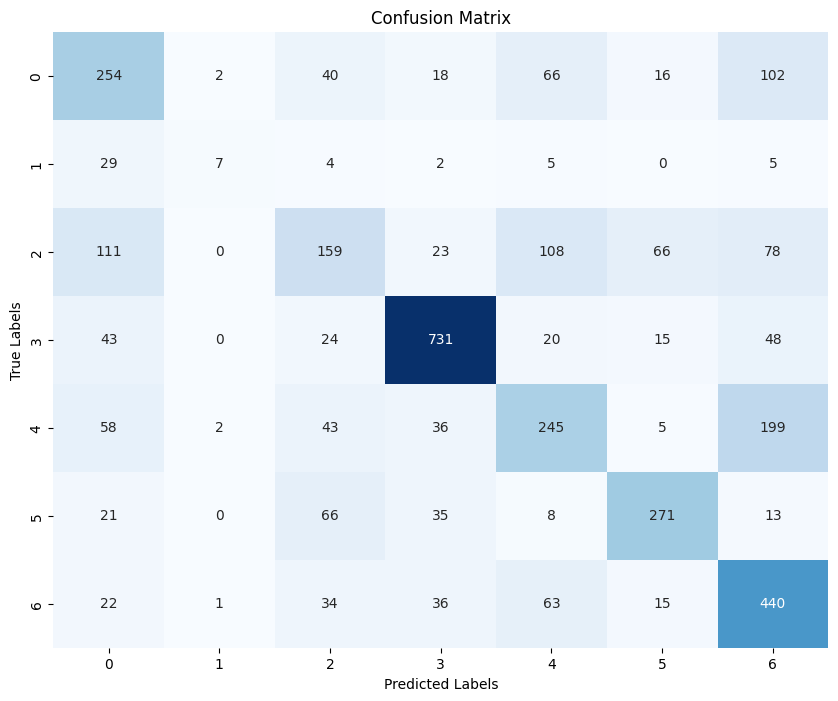

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model's predictions for the test set
y_pred = model.predict(X_test)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.47      0.51      0.49       498
           1       0.58      0.13      0.22        52
           2       0.43      0.29      0.35       545
           3       0.83      0.83      0.83       881
           4       0.48      0.42      0.44       588
           5       0.70      0.65      0.68       414
           6       0.50      0.72      0.59       611

    accuracy                           0.59      3589
   macro avg       0.57      0.51      0.51      3589
weighted avg       0.59      0.59      0.58      3589

